This notebook generates ballot-, candidate-, and party-MDS plots.

In [2]:
import glob
import sys
sys.path.append('..')
from Clustering_Functions import *
from sklearn.manifold import MDS  # type: ignore
import numpy as np
import seaborn as sns

BALLOT MDS PLOTS FROM PENTLAND HILLS

In [4]:
filename = '../scot-elex/7_cands/edinburgh_2017_ward2.csv'
num_cands, election, cand_list, ward = csv_parse(filename)
parties = party_abrevs(cand_list)

In [5]:
C2 = kmeans(election, k=2)
C3 = kmeans(election, k=3)

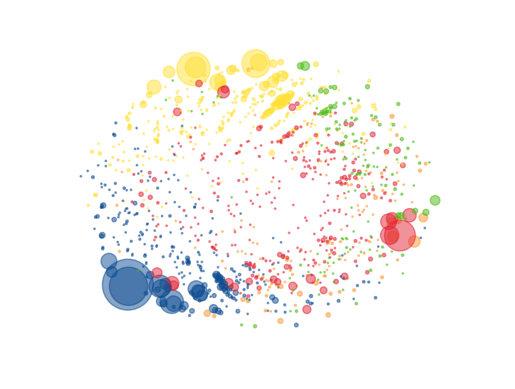

In [7]:
projections, error = Ballot_MDS_plot(election, party_names=parties, return_data=True, threshold=1)

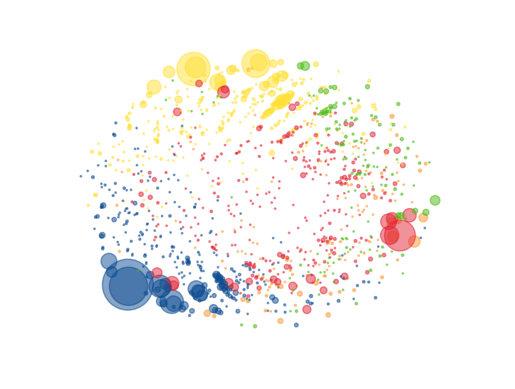

In [9]:
Ballot_MDS_plot(election, party_names=parties, threshold=1,projections=projections, filename='PH_party.png', dpi=100)

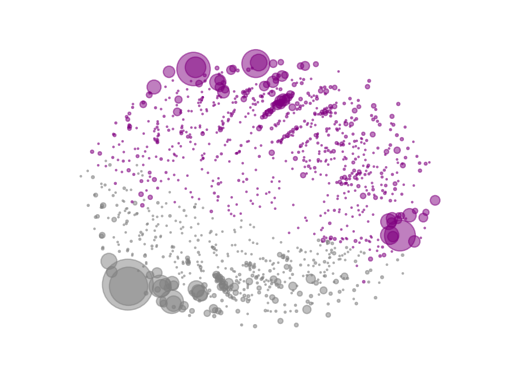

In [10]:
Ballot_MDS_plot(election, clusters=C2, projections=projections, threshold=1, filename='PH_2_means.png', dpi=100)

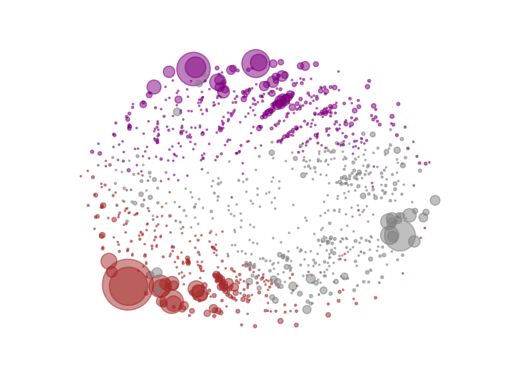

In [12]:
Ballot_MDS_plot(election, clusters=C3, projections=projections, threshold=1,filename='PH_3_means.png', dpi=100)

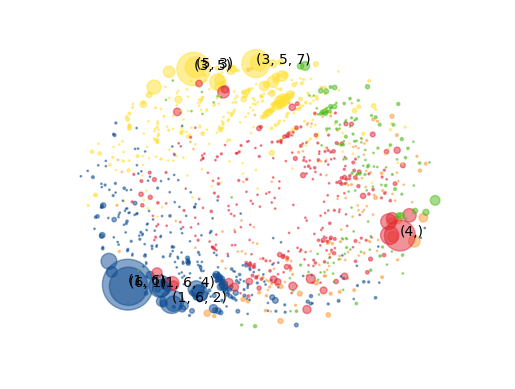

In [15]:
Ballot_MDS_plot(election, party_names=parties, threshold=1,projections=projections, label_threshold = 200)

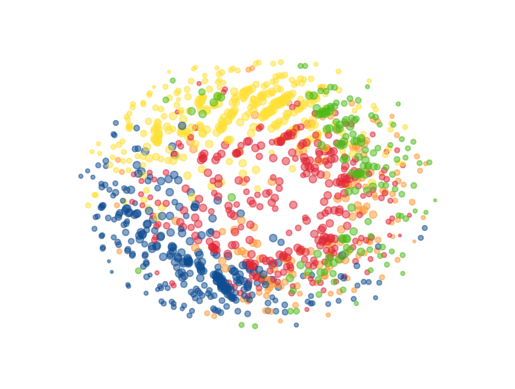

In [27]:
Ballot_MDS_plot(election, party_names=parties, threshold=1,projections=projections, filename='PH_ballot_length.png', dpi=100)

In [26]:
def Ballot_MDS_plot(election, clusters = None, num_cands = 'Auto', dimension = 2, n_init = 100, proxy='Borda', borda_style='pes',
                       threshold=10, label_threshold = np.infty, metric = 'Euclidean', 
                       party_names=None, filename=None, dpi = 600, 
                       projections = 'Auto', return_data = False):
    """
    Displays an MDS (multi-dimensional scaling) plot for the proxies of all of the ballots in the election that received at least the given threshold number of votes.
    If clusters is provided, they are colored by their cluster assignments; otherwise, by party of 1st place vote.
    
    Args:
        election : a dictionary matching ballots to weights.
        clusters : if a clustering is provided, it will color by cluster assignment.
        dimension : choice of {1,2,3} for the dimension of the MDS plot.
        n_init : The number of times the SMACOF algorith will run with different initialializations.
        proxy : choice of {'Borda', 'HH'} for Borda or head-to-head proxy vectors.
        borda_style : choice of {'pes', 'avg'}, which is passed to Borda_vector (only used if proxy == 'Borda') 
        threshold : it ignores all ballots that were cast fewer than the threshold number of times.
        label_threshold : it labels all ballots that were cast at least the label_threshold number of times (set label_threshold=np.infty for no labeling)
        metric : choice of {'Euclidean', 'Manhattan'} for the proxy metric that's approximated.
        party_names : if provided, it will color by party of first place vote.
        filename : to save the plot.   
        projections: (optional) entering projections is useful for constructing multiple MDS plots of the same election using a common projection. 
        return_data: useful if you want to know the projection error, or for constructing multiple MDS plots of the same election using a common projection.
    Returns:
        projections, error (if return_data is set to True)
    """

    if num_cands == 'Auto':
        num_cands = max([item for ranking in election.keys() for item in ranking])

    cluster_palat = ['grey','purple','brown','orange','b','c','g', 'r', 'm', 'y']
    party_palat_dic = {'SNP':'#FFE135', 'Lab': '#E32636', 'Con':'#0F4D92','LD':'#FF9933','Gr':'#4CBB17', 'Ind': '#008B8B'}

    ballots = []
    proxies = []
    weights = []
    ballot_lengths = []
    colors = []

    for ballot, weight in election.items():
        if weight>=threshold:
            if proxy=='Borda':
                ballot_proxy = Borda_vector(ballot,num_cands=num_cands, borda_style=borda_style)
            else:
                ballot_proxy = HH_proxy(ballot,num_cands=num_cands)
            ballots.append(ballot)
            proxies.append(ballot_proxy)
            weights.append(weight)
            ballot_lengths.append(4*len(ballot))

            if party_names != None: # color by party of first place vote
                party = party_names[ballot[0]-1]
                color = party_palat_dic[party] if party in party_palat_dic.keys() else 'black'
                colors.append(color)
            elif clusters != None: # color by cluster assignment
                cluster_assigment = []
                for cluster_num in range(len(clusters)):
                    C = clusters[cluster_num]
                    if ballot in C.keys():
                        cluster_assigment.append(cluster_num)
                if len(cluster_assigment) == 0:
                    color = 'black'
                elif len(cluster_assigment) == 1:
                    color = cluster_palat[cluster_assigment[0]]
                else:
                    color = 'white'
                colors.append(color)
            else: # color everything black
                colors.append('black')

    if metric == 'Euclidean':
        similarities = euclidean_distances(proxies)
    else:
        similarities = manhattan_distances(proxies)
    if type(projections) == str: # if projections == 'Auto'
        model = MDS(n_components=dimension, dissimilarity='precomputed', n_init=n_init)
        projections = model.fit_transform(similarities)
        error = model.stress_
    else:
        error = None

    X = np.array([p[0] for p in projections])
    Y = np.array([p[1] for p in projections]) if dimension>1 else np.array([0 for _ in range(len(X))])

    if dimension<3:
        fig, ax = plt.subplots()
        ax.scatter(X,Y, s = ballot_lengths, c = colors, alpha = .5)
        x_margin = (max(X) - min(X)) * 0.2  # 20% margin
        plt.xlim(min(X) - x_margin, max(X) + x_margin)
        if dimension == 2:
            y_margin = (max(Y) - min(Y)) * 0.2  # 20% margin
            plt.ylim(min(Y) - y_margin, max(Y) + y_margin)
        ax.grid(False)
        ax.axis('off')
    else:
        Z = np.array([p[2] for p in projections])
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X,Y,Z, c=colors, s=weights)
        ax.set(xticklabels=[], yticklabels=[], zticklabels=[])        


    for count in range(len(proxies)):
        if weights[count]>label_threshold:
            if dimension == 3:
                ax.text(X[count],Y[count],Z[count], f"{ballots[count]}")
            else:
                ax.annotate(ballots[count], xy=(X[count], Y[count]))

    if filename == None:
        plt.show()
    else:
        plt.savefig(filename, dpi = dpi)

    if return_data:
        return projections, error


In [ ]:
dif, perm = Clustering_closeness(election, C_mod, C_3means, return_perm=True)
# re-order the pieces of one of the clusterings to best match with the pieces of the other
C_3means_ordered = [C_3means[n] for n in perm]
# Display all three with a common projection
projections, error = Ballot_MDS_plot(election, party_names=parties, return_data=True) #colored by party of first place vote
Ballot_MDS_plot(election, C_mod, projections=projections) #colored by 3-means assignment
Ballot_MDS_plot(election, C_3means_ordered,projections=projections) # colored by modularity assignment
print(f"Modularity = {modularity}.  Closeness = {dif}.")

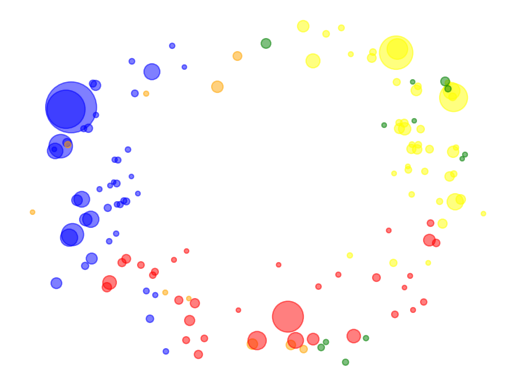

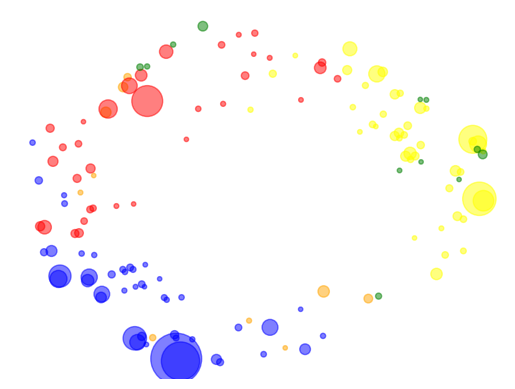

In [3]:
for trial in range(1,3):
    Ballot_MDS_plot(election, party_names=parties, filename=f"plots/PH_ballots_trial{trial}.jpg")

CANDIDATE MDS PLOTS FOR PENTLAND HILLS

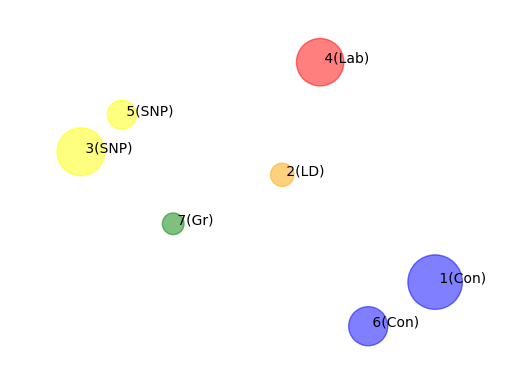

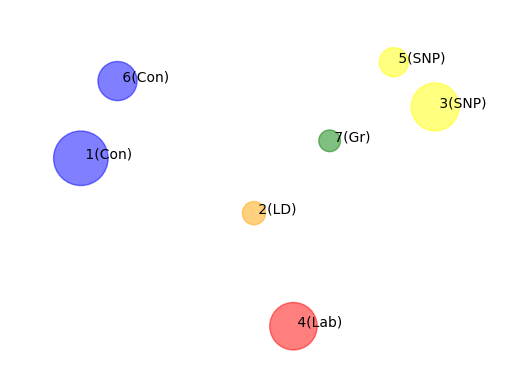

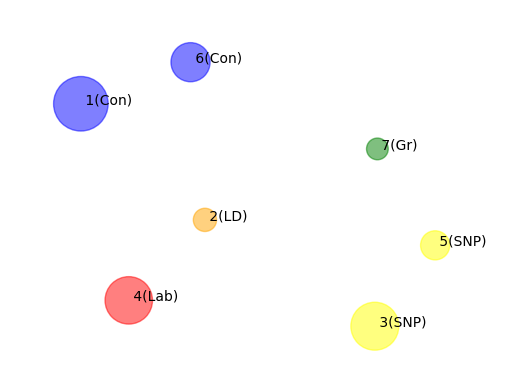

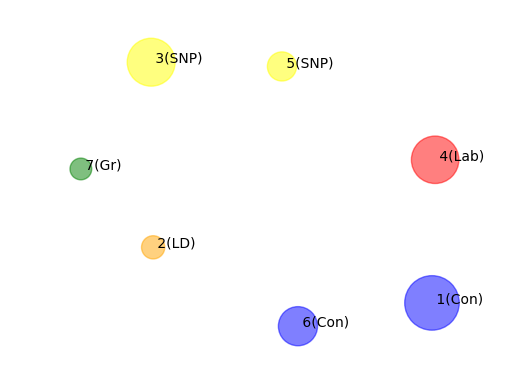

In [4]:
ls = [('borda',None),('borda_completion',None)]

for method,trunc in ls:
    for trial in range(1,3):
        name = f"plots/PH_{method}_trial{trial}.jpg"
        Candidate_MDS_plot(election, method=method, trunc = trunc, party_names=parties, party_colors='Auto', filename = name)

Next we'll create an MDS plot for the five major parties.  The distance between two parties is the average distance between candidates from those two parties running against each other (over all such candidate pairs in all elections).  We'll size the markers by the portion of first place votes that the party received (over all elections).

In [5]:
top_parties = ['SNP', 'Lab', 'Con', 'LD', 'Gr']
party_colors = ['yellow', 'red', 'blue', 'orange', 'green']

In [6]:
def Party_MDS_plot(top_parties=['SNP', 'Lab', 'Con', 'LD', 'Gr'], filename_list = 'Auto',
                   method = 'borda_completion', trunc = None, marker_scale = 5000, filename=None):
    if filename_list == 'Auto':
        filename_list = glob.glob("scot-elex/**/*.csv")

    # First generate first place vote tallies and pairwise distance matrix.
    pair_counts =  pd.DataFrame(np.zeros([len(top_parties),len(top_parties)]), index = top_parties, columns=top_parties)
    to_return =    pd.DataFrame(np.zeros([len(top_parties),len(top_parties)]), index = top_parties, columns=top_parties)
    party_fpv_counts = {party:0 for party in top_parties}

    for file in filename_list:
        num_cands, election, cand_names, location = csv_parse(file)
        party_list = party_abrevs(cand_names)
        
        # tally party first place votes
        for ballot, weight in election.items():
            party = party_list[ballot[0]-1]
            if party in top_parties:
                party_fpv_counts[party]+=weight
        
        # create pairwise distance matrix
        M = Candidate_dist_matrix(election, method = method, trunc=trunc)
        for i in range(len(party_list)):
            for j in range(len(party_list)):
                if i != j:
                    pi = party_list[i]
                    pj = party_list[j]
                    if pi in top_parties and pj in top_parties:
                        weight = M[i,j]
                        to_return[pi][pj] += weight/num_cands
                        pair_counts[pi][pj] +=1
    total = sum(party_fpv_counts.values())
    party_fpv_counts={x:y/total for x,y in party_fpv_counts.items()}
    M = to_return/pair_counts
    M = M.fillna(value=0.01)

    # Next generate the MDS plot
    projections = MDS(n_components=2, dissimilarity='precomputed').fit_transform(M)
    X = np.array([p[0] for p in projections])
    Y = np.array([p[1] for p in projections])

    fig, ax = plt.subplots()

    s = [marker_scale*party_fpv_counts[party] for party in top_parties]

    ax.scatter(X,Y, s=s, c = party_colors,alpha=.5)
    for count in range(len(top_parties)):
        ax.annotate(f" {top_parties[count]}", xy=(X[count], Y[count]))

    x_margin = (max(X) - min(X)) * 0.2  # 20% margin
    y_margin = (max(Y) - min(Y)) * 0.2  # 20% margin
    plt.xlim(min(X) - x_margin, max(X) + x_margin)
    plt.ylim(min(Y) - y_margin, max(Y) + y_margin)
    ax.grid(False)
    ax.axis('off')
    if filename != None:
        plt.savefig(filename, dpi=600)
    plt.show()

In [7]:
for year in [2012, 2017, 2022]:
    test = glob.glob(f"scot-elex/**/*{year}*.csv")
    print(year, len(test))

2012 353
2017 351
2022 345


plots/Parties_borda_completion_allyears_trial1.jpg


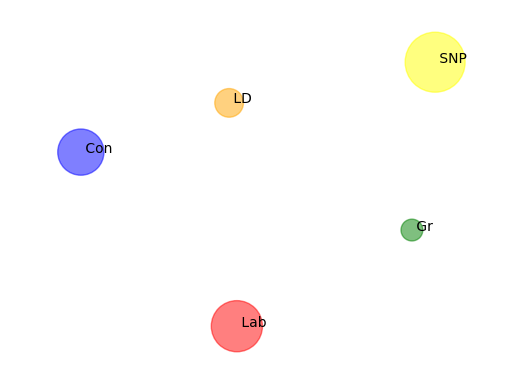

plots/Parties_borda_completion_2012_trial1.jpg


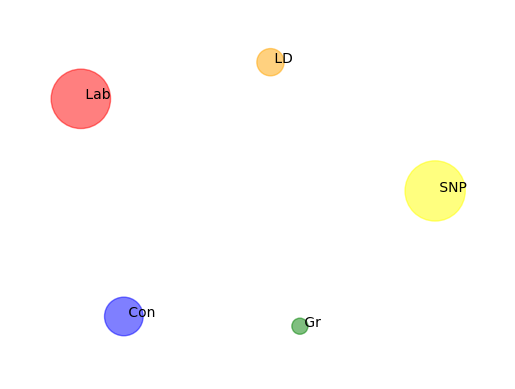

plots/Parties_borda_completion_2017_trial1.jpg


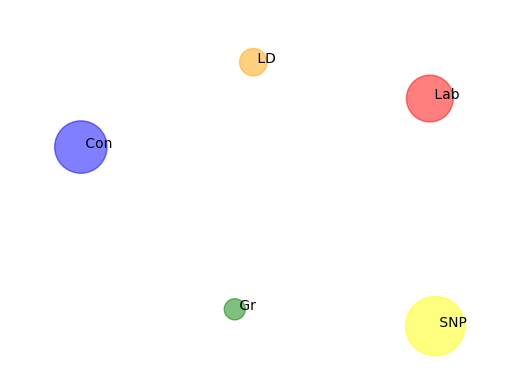

plots/Parties_borda_completion_2022_trial1.jpg


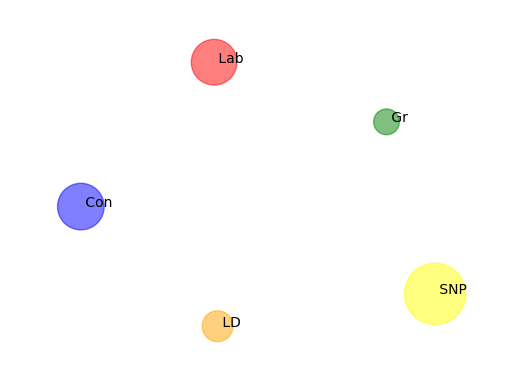

plots/Parties_borda_completion_allyears_trial2.jpg


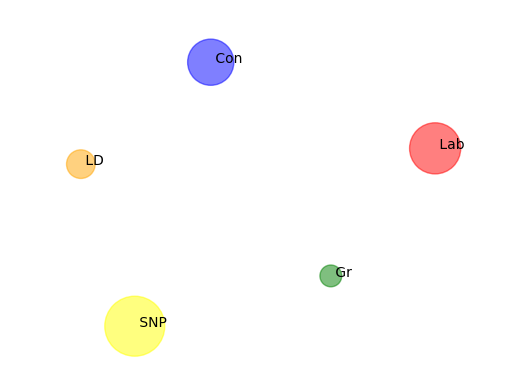

plots/Parties_borda_completion_2012_trial2.jpg


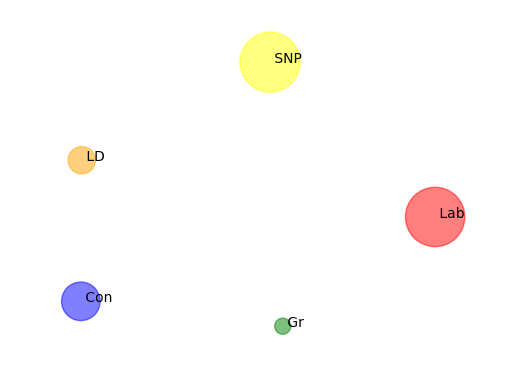

plots/Parties_borda_completion_2017_trial2.jpg


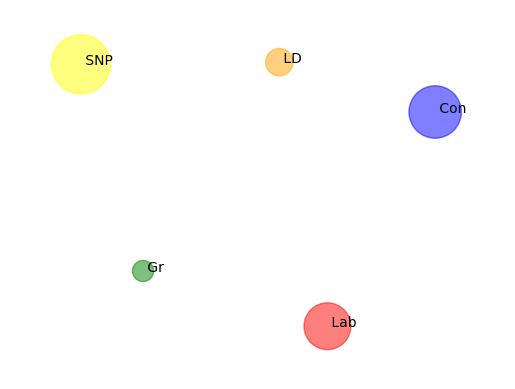

plots/Parties_borda_completion_2022_trial2.jpg


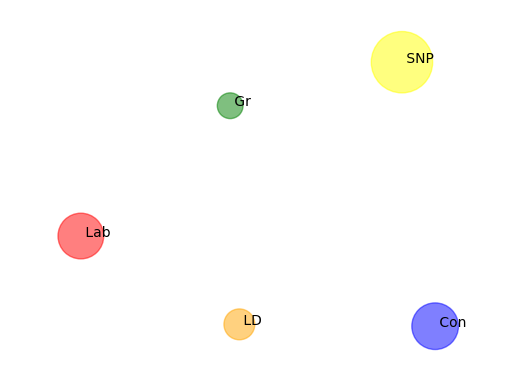

plots/Parties_borda_allyears_trial1.jpg


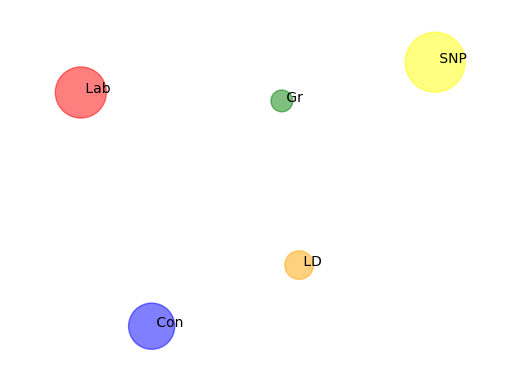

plots/Parties_borda_2012_trial1.jpg


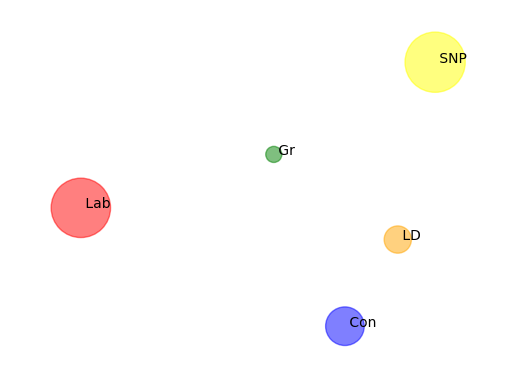

plots/Parties_borda_2017_trial1.jpg


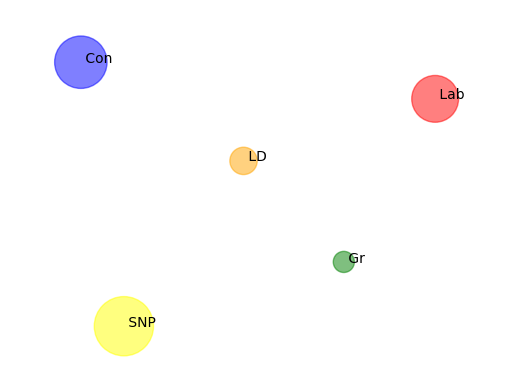

plots/Parties_borda_2022_trial1.jpg


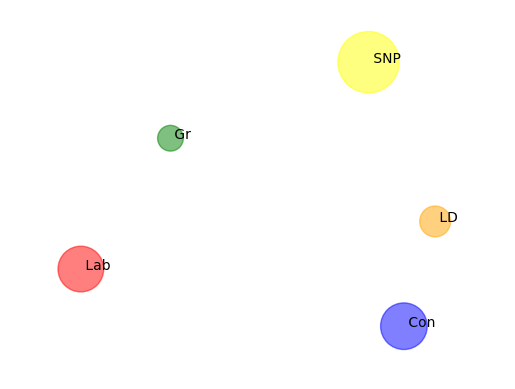

plots/Parties_borda_allyears_trial2.jpg


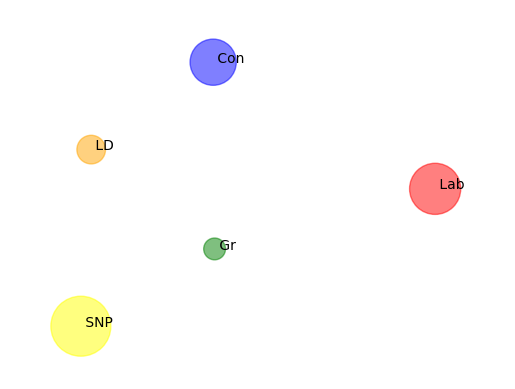

plots/Parties_borda_2012_trial2.jpg


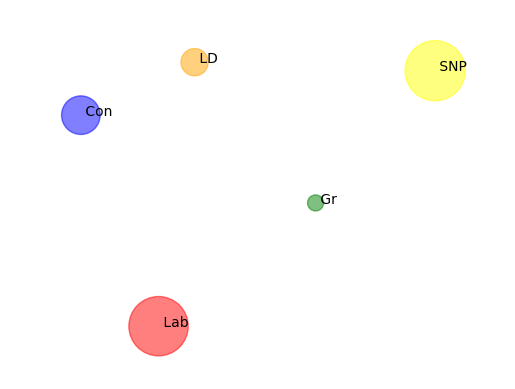

plots/Parties_borda_2017_trial2.jpg


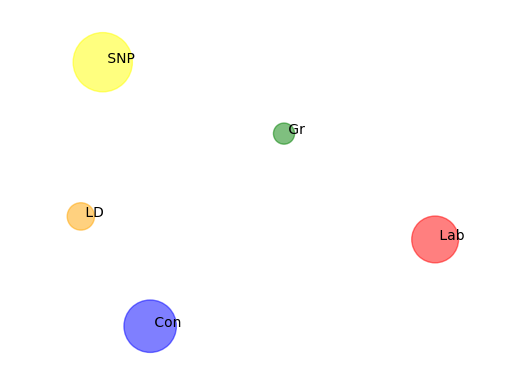

plots/Parties_borda_2022_trial2.jpg


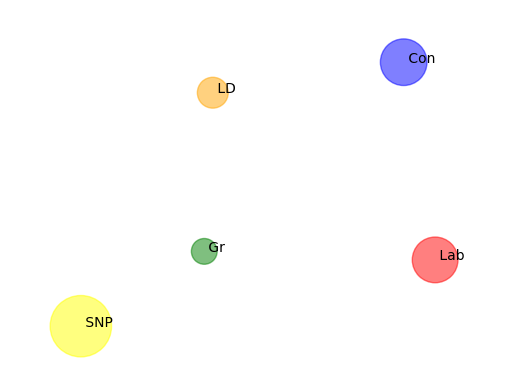

plots/Parties_successive_allyears_trial1.jpg


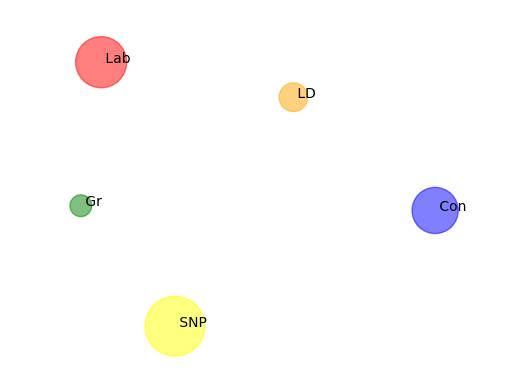

plots/Parties_successive_2012_trial1.jpg


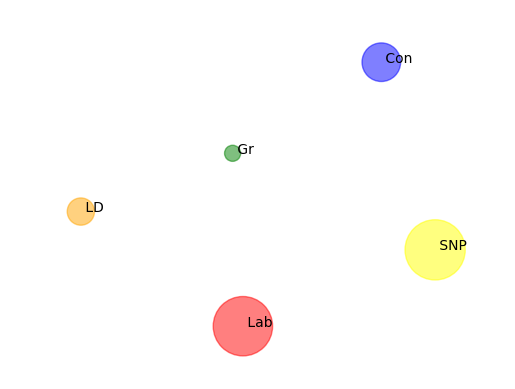

plots/Parties_successive_2017_trial1.jpg


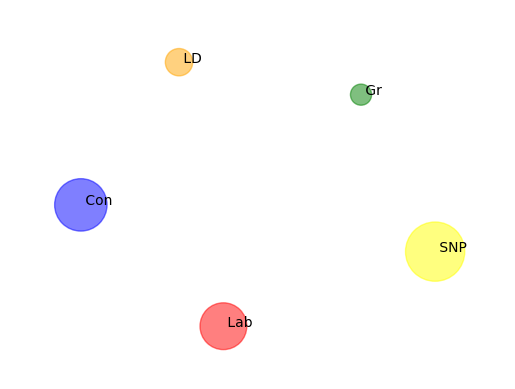

plots/Parties_successive_2022_trial1.jpg


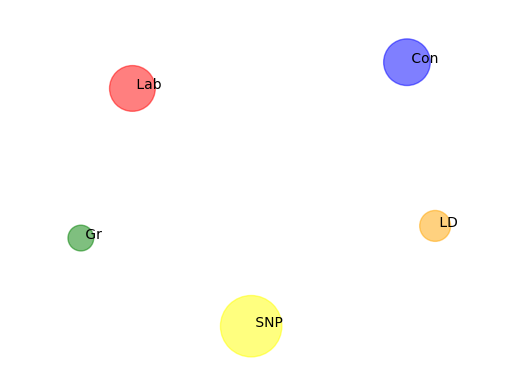

plots/Parties_successive_allyears_trial2.jpg


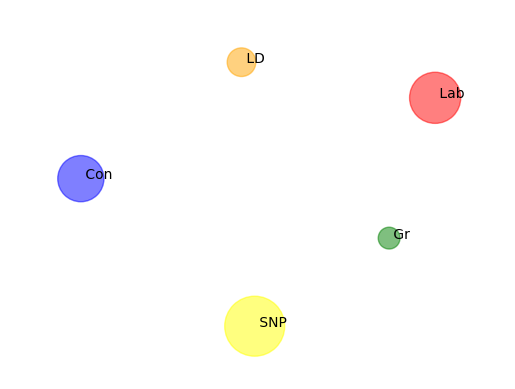

plots/Parties_successive_2012_trial2.jpg


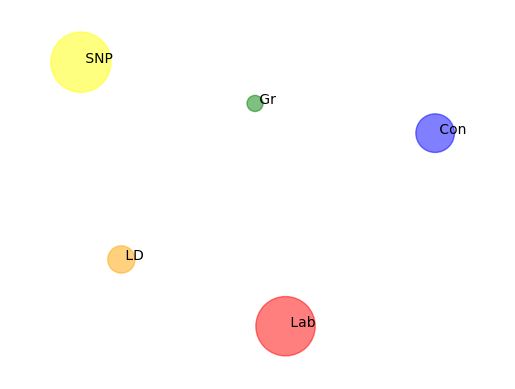

plots/Parties_successive_2017_trial2.jpg


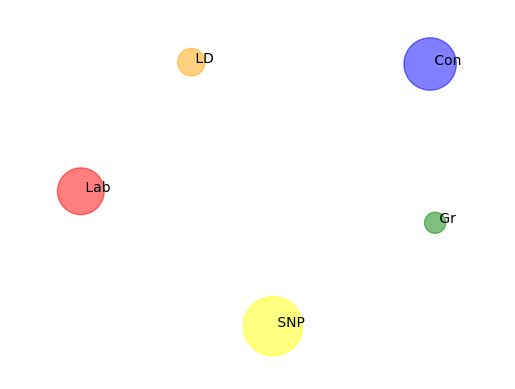

plots/Parties_successive_2022_trial2.jpg


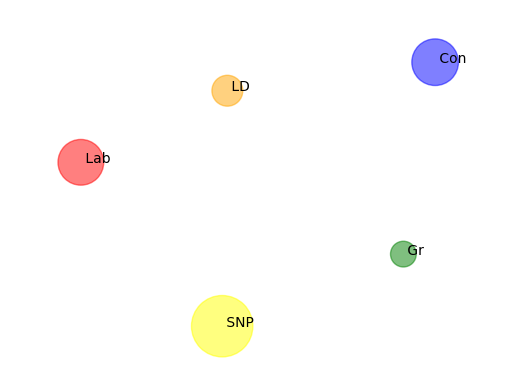

plots/Parties_coappearances_allyears_trial1.jpg


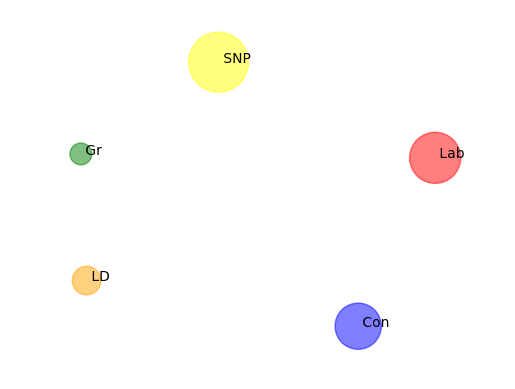

plots/Parties_coappearances_2012_trial1.jpg


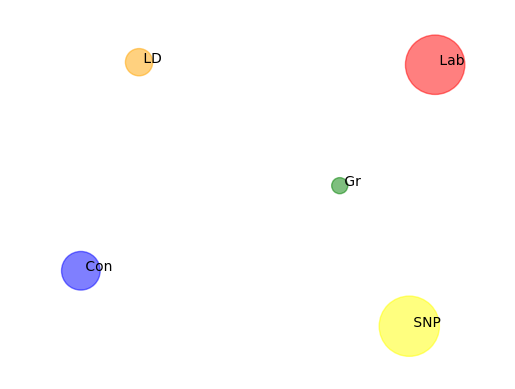

plots/Parties_coappearances_2017_trial1.jpg


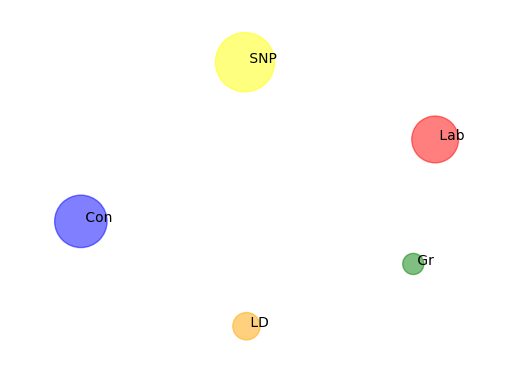

plots/Parties_coappearances_2022_trial1.jpg


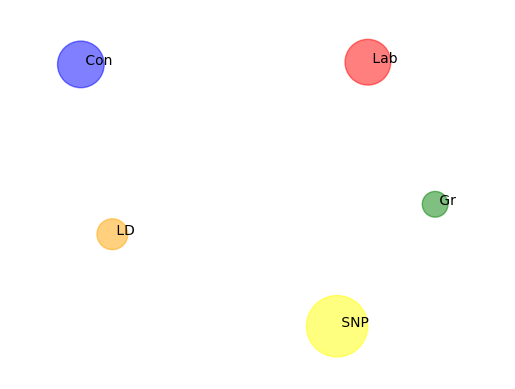

plots/Parties_coappearances_allyears_trial2.jpg


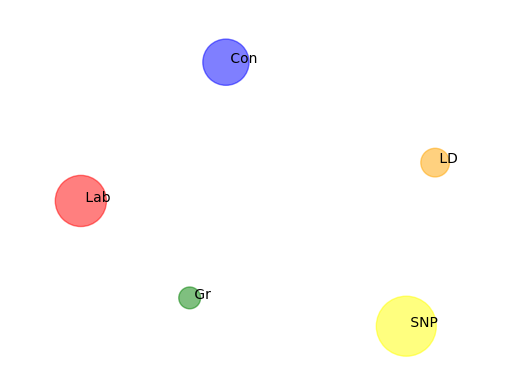

plots/Parties_coappearances_2012_trial2.jpg


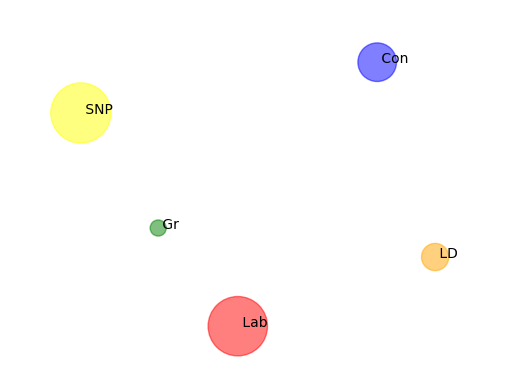

plots/Parties_coappearances_2017_trial2.jpg


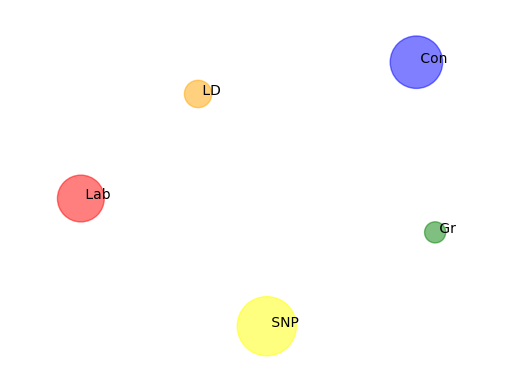

plots/Parties_coappearances_2022_trial2.jpg


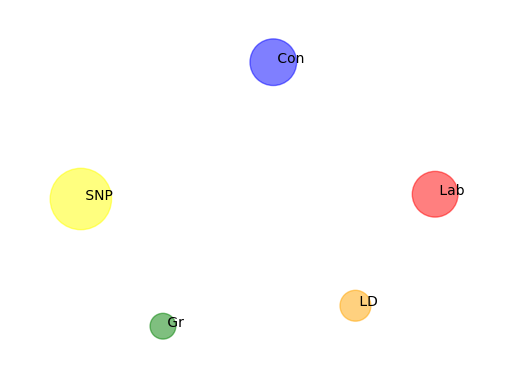

In [8]:
for method in ['borda_completion','borda','successive', 'coappearances']:
    for trial in [1,2]:
        filename_list = glob.glob(f"scot-elex/**/**.csv")
        name = f"plots/Parties_{method}_allyears_trial{trial}.jpg"
        print(name)
        Party_MDS_plot(method=method, filename_list=filename_list, filename=name)
        for year in [2012, 2017, 2022]:
            filename_list = glob.glob(f"scot-elex/**/*{year}*.csv")
            name = f"plots/Parties_{method}_{year}_trial{trial}.jpg"
            print(name)
            Party_MDS_plot(method=method, filename_list=filename_list, filename=name)

Now let's separate out the portion of the above code that created the pairwise distance matrix, so that we can study the matrix alone.

In [9]:
def Party_dist_matrix(top_parties=['SNP', 'Lab', 'Con', 'LD', 'Gr'], filename_list = 'Auto',
                   method = 'borda_completion', trunc = None):
    if filename_list == 'Auto':
        filename_list = glob.glob("scot-elex/**/*.csv")

    pair_counts =  pd.DataFrame(np.zeros([len(top_parties),len(top_parties)]), index = top_parties, columns=top_parties)
    to_return =    pd.DataFrame(np.zeros([len(top_parties),len(top_parties)]), index = top_parties, columns=top_parties)

    for file in filename_list:
        num_cands, election, cand_names, location = csv_parse(file)
        party_list = party_abrevs(cand_names)
    
        M = Candidate_dist_matrix(election, method = method, trunc=trunc)
        for i in range(len(party_list)):
            for j in range(len(party_list)):
                if i != j:
                    pi = party_list[i]
                    pj = party_list[j]
                    if pi in top_parties and pj in top_parties:
                        weight = M[i,j]
                        to_return[pi][pj] += weight/num_cands
                        pair_counts[pi][pj] +=1

    M = to_return/pair_counts
    M = M.fillna(value=0.01)
    return M

In [10]:
M_12 = Party_dist_matrix(method = 'borda_completion',filename_list = glob.glob(f"scot-elex/**/*2012*.csv"))
M_17 = Party_dist_matrix(method = 'borda_completion',filename_list = glob.glob(f"scot-elex/**/*2017*.csv"))
M_22 = Party_dist_matrix(method = 'borda_completion',filename_list = glob.glob(f"scot-elex/**/*2022*.csv"))

N_12 = Party_dist_matrix(method = 'borda',filename_list = glob.glob(f"scot-elex/**/*2012*.csv"))
N_17 = Party_dist_matrix(method = 'borda',filename_list = glob.glob(f"scot-elex/**/*2017*.csv"))
N_22 = Party_dist_matrix(method = 'borda',filename_list = glob.glob(f"scot-elex/**/*2022*.csv"))

In [11]:
N_d1 = N_17-N_12
N_d2 = N_22-N_17
N_d3 = N_22-N_12
M_d1 = M_17-M_12
M_d2 = M_22-M_17
M_d3 = M_22-M_12

In [12]:
def Heatmap(M):
    Mc = M.copy()
    for i in range(len(Mc)):
        for j in range(len(Mc)):
            if i>=j:
             Mc.iloc[i,j] = np.nan
    sns.heatmap(Mc, cmap = 'vlag')

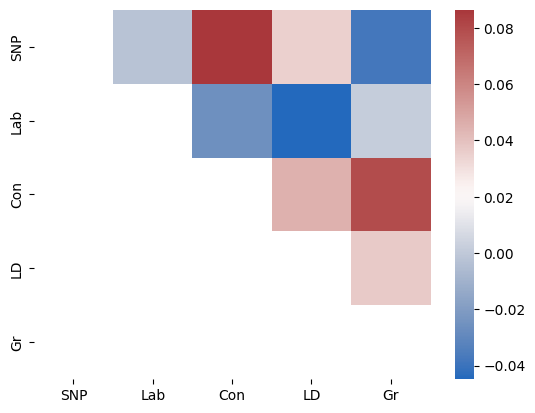

In [13]:
Heatmap(N_d3)

In [14]:
Decade = pd.DataFrame(np.zeros([len(top_parties),len(top_parties)]), index = top_parties, columns=top_parties)
for i in range(len(Decade)):
    for j in range(len(Decade)):
            if i>=j:
                Decade.iloc[i,j] = ' '
            else:
                 d = f"({round(N_17.iloc[i,j]-N_12.iloc[i,j],2)} , {round(N_22.iloc[i,j]-N_17.iloc[i,j],2)})"
                 Decade.iloc[i,j] = d

In [15]:
Decade

,SNP,Lab,Con,LD,Gr
SNP,,"(-0.02 , 0.02)","(0.09 , -0.0)","(0.02 , 0.02)","(-0.04 , 0.0)"
Lab,,,"(-0.02 , -0.01)","(-0.05 , 0.0)","(-0.01 , 0.01)"
Con,,,,"(0.05 , -0.0)","(0.07 , 0.01)"
LD,,,,,"(-0.0 , 0.04)"
Gr,,,,,


In [16]:
Decade.to_csv('tables/Decade.csv')